In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True)

In [3]:
print(trainset)
print(validationset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [4]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [5]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

We're using => cuda:0
CNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [6]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [7]:
a = next(iter(train_loader))
a[0].size()

torch.Size([64, 1, 28, 28])

In [8]:
len(trainset)

60000

Ankle Boot


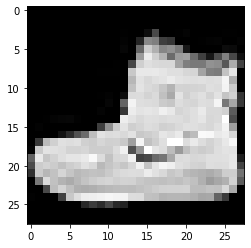

In [9]:
image, label = next(iter(trainset))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

Trouser
torch.Size([64, 1, 28, 28]) torch.Size([64])


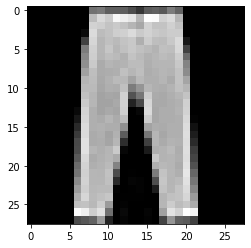

In [10]:
image, label = next(iter(train_loader))
plt.imshow(image[10].squeeze(), cmap="gray")
print(output_label(label[10]))
print(image.size(), label.size())

In [11]:
def Accuracy(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [12]:
print("Begin training.")
for e in tqdm(range(5)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    batch_num = 1
    model.train()
    for X_train_batch, y_train_batch in tqdm(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        #print(y_train_pred)
        #y_train_pred = y_train_pred.argmax(1)
        #print(y_train_pred.size(), y_train_batch.size())
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = Accuracy(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        #print(f'{batch_num+0:02}: | Train Acc: {train_acc} | Train Loss: {train_loss.item()}')
        batch_num += 1
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.5f}')

Begin training.



Epoch 00: | Train Loss: 0.42658 | Train Acc: 85.04584



Epoch 01: | Train Loss: 0.29322 | Train Acc: 89.66205



Epoch 02: | Train Loss: 0.25460 | Train Acc: 90.96482



Epoch 03: | Train Loss: 0.23274 | Train Acc: 91.70896



Epoch 04: | Train Loss: 0.21102 | Train Acc: 92.39339



In [13]:
#TESTING
y_pred_list = []
y_true_list = []
correct_results_sum = 0
num_samples = 0
with torch.no_grad():
    for x_batch, y_batch in tqdm(val_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        correct_results_sum += (y_pred_tag == y_batch).sum()
        num_samples += len(y_batch)
acc = correct_results_sum.float()/num_samples
acc = torch.round(acc * 100)
print(f'Accuracy: {acc}')


Accuracy: 91.0


In [14]:
y_pred = []
y_true = []
for i in range(len(y_true_list)):
    for j in range(len(y_true_list[i])):
        y_pred.append(y_pred_list[i][j])
        y_true.append(y_true_list[i][j])
len(y_true), len(y_pred)

(10000, 10000)

In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.98      0.99      0.98      1000
           2       0.85      0.89      0.87      1000
           3       0.94      0.88      0.91      1000
           4       0.81      0.92      0.86      1000
           5       0.99      0.98      0.99      1000
           6       0.79      0.69      0.74      1000
           7       0.90      0.99      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.99      0.91      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

